In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cvp
from csss import CSSS
import time 
%matplotlib inline

Import the data and drop rows with NAN.

In [2]:
df=pd.read_csv('data/input_data.csv')
df=df.dropna()
df.head()

,Unnamed: 0,Irradiance,Real_Power_PV,Reactive_Power_Total,Real_Power_Total,Reactive_Power_PV,Apparent_PF,Load_PF,IrradianceProxy
4,2015-10-19 00:05:00,0.0,-8541.426900,93436.828486,2.272701e+06,20196.778217,0.999437,0.999099,-0.123
5,2015-10-19 00:06:00,0.0,-8508.470760,89276.971324,2.292255e+06,20141.073082,0.999323,0.998960,-0.123
6,2015-10-19 00:07:00,0.0,-8506.476367,82404.913996,2.248452e+06,20153.905945,0.999618,0.999329,-0.123
7,2015-10-19 00:08:00,0.0,-8516.111864,78883.928122,2.292161e+06,20138.402632,0.999417,0.999077,-0.123
8,2015-10-19 00:09:00,0.0,-8522.429096,78834.360069,2.310943e+06,20158.145410,0.998981,0.998549,-0.123


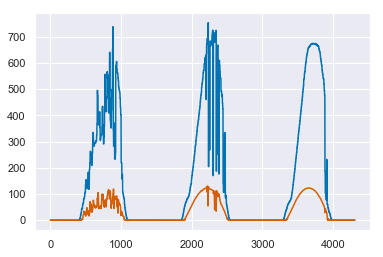

In [3]:
### Look at the solar proxies
plt.plot(df['Irradiance'])
plt.plot(df['IrradianceProxy'],'-r')

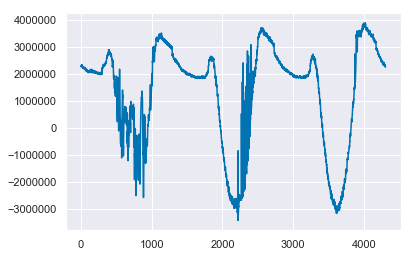

In [4]:
### Look at the total load shape
plt.plot(df['Real_Power_Total'])

In [5]:
# Feeder-level Solar Disagg Using the New Class
N = len(df)
CSSS_solar = CSSS(np.array(df['Real_Power_Total']))  ## Instantiate model with aggregate signal, Y
CSSS_solar.addSource(
    np.vstack((np.ones((1,N)),np.array(df['Reactive_Power_Total']))).transpose(),
    alpha = 1,
    name = 'Load',
    costFunction='l2'
)  ## Add a model for Load:  Q + intercept term as regressor
CSSS_solar.addSource(
    np.array(df['IrradianceProxy']),
    alpha = .5,
    name = 'Solar',
    costFunction = 'l2'
) ## Add a model for Solar: Irradiance Proxy Only as regressor.

## Constrain Solar to be <= 0 . 
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'] <= 0 )
## Constrain Load to be >=0
CSSS_solar.addConstraint(CSSS_solar.models['Load']['source'] >= 0 )

start=time.time()
a=CSSS_solar.constructSolve()
print("It took {:.2f} seconds in centralized CSSS".format(time.time()-start))
    

It took 1.12 seconds in centralized CSSS


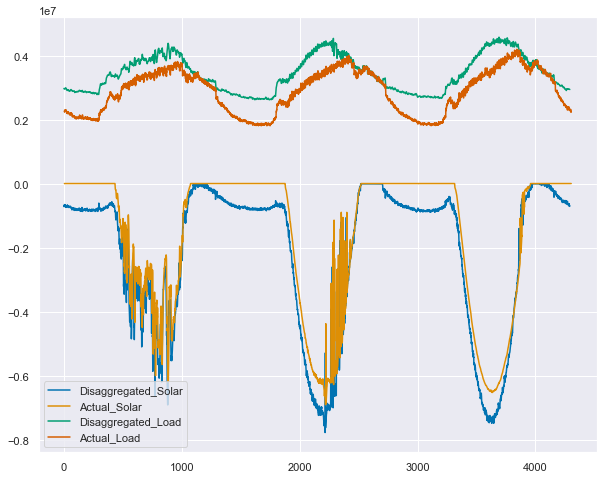

In [9]:
plt.figure(figsize=(10,8))

plt.plot(CSSS_solar.models['Solar']['source'].value, label = 'Disaggregated_Solar')
plt.plot(-1*df['Real_Power_PV'], label = 'Actual_Solar')
plt.plot(CSSS_solar.models['Load']['source'].value, label = 'Disaggregated_Load')
plt.plot(df['Real_Power_Total']+df['Real_Power_PV'], label = 'Actual_Load')

plt.legend()
plt.show()